In [3]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt
nnfs.init()

In [4]:
# Dense layer
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from input ones, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


In [5]:
# ReLU activation
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let’s make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

In [6]:
# Softmax activation
class Activation_Softmax:
 # Forward pass
 def forward(self, inputs):
 # Get unnormalized probabilities
  exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
 # Normalize them for each sample
  probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
  self.output = probabilities

In [7]:
# Common loss class
class Loss:
 # Calculates the data and regularization losses
 # given model output and ground truth values
 def calculate(self, output, y):
  # Calculate sample losses
  sample_losses = self.forward(output, y)
  # Calculate mean loss
  data_loss = np.mean(sample_losses)
  # Return loss
  return data_loss

In [8]:
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [9]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy:
    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

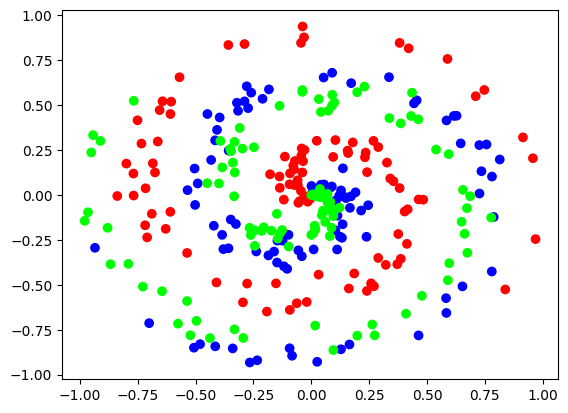

In [10]:
X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
plt.show()

In [11]:
# SGD optimizer
class Optimizer_SGD:
 # Initialize optimizer - set settings,
 # learning rate of 1. is default for this optimizer
 def __init__(self, learning_rate=0.5):
  self.learning_rate = learning_rate
 # Update parameters
 def update_params(self, layer):
  layer.weights += -self.learning_rate * layer.dweights
  layer.biases += -self.learning_rate * layer.dbiases

In [12]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_SGD()

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)


epoch: 0, acc: 0.343, loss: 1.099
epoch: 100, acc: 0.407, loss: 1.095
epoch: 200, acc: 0.423, loss: 1.079
epoch: 300, acc: 0.463, loss: 1.074
epoch: 400, acc: 0.457, loss: 1.072
epoch: 500, acc: 0.447, loss: 1.070
epoch: 600, acc: 0.430, loss: 1.069
epoch: 700, acc: 0.427, loss: 1.068
epoch: 800, acc: 0.437, loss: 1.067
epoch: 900, acc: 0.430, loss: 1.065
epoch: 1000, acc: 0.430, loss: 1.063
epoch: 1100, acc: 0.433, loss: 1.062
epoch: 1200, acc: 0.437, loss: 1.060
epoch: 1300, acc: 0.440, loss: 1.059
epoch: 1400, acc: 0.437, loss: 1.056
epoch: 1500, acc: 0.430, loss: 1.053
epoch: 1600, acc: 0.450, loss: 1.049
epoch: 1700, acc: 0.450, loss: 1.044
epoch: 1800, acc: 0.460, loss: 1.039
epoch: 1900, acc: 0.470, loss: 1.032
epoch: 2000, acc: 0.450, loss: 1.047
epoch: 2100, acc: 0.443, loss: 1.046
epoch: 2200, acc: 0.440, loss: 1.045
epoch: 2300, acc: 0.453, loss: 1.043
epoch: 2400, acc: 0.450, loss: 1.040
epoch: 2500, acc: 0.443, loss: 1.038
epoch: 2600, acc: 0.460, loss: 1.035
epoch: 2700, 

In [13]:
class LearningRateDecayOptimizer:
     # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        layer.weights += -self.current_learning_rate * layer.dweights
        layer.biases += -self.current_learning_rate * layer.dbiases

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


In [14]:
import numpy as np

# Assuming the necessary classes (Layer_Dense, Activation_ReLU, 
# Activation_Softmax_Loss_CategoricalCrossentropy, and spiral_data) are defined elsewhere

X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = LearningRateDecayOptimizer(decay=1e-3)

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()


epoch: 0, acc: 0.390, loss: 1.099, lr: 1.0
epoch: 100, acc: 0.383, loss: 1.092, lr: 0.9099181073703367
epoch: 200, acc: 0.407, loss: 1.079, lr: 0.8340283569641367
epoch: 300, acc: 0.420, loss: 1.077, lr: 0.7698229407236336
epoch: 400, acc: 0.427, loss: 1.076, lr: 0.7147962830593281
epoch: 500, acc: 0.423, loss: 1.076, lr: 0.66711140760507
epoch: 600, acc: 0.427, loss: 1.075, lr: 0.6253908692933083
epoch: 700, acc: 0.427, loss: 1.073, lr: 0.5885815185403178
epoch: 800, acc: 0.417, loss: 1.071, lr: 0.5558643690939411
epoch: 900, acc: 0.417, loss: 1.068, lr: 0.526592943654555
epoch: 1000, acc: 0.413, loss: 1.063, lr: 0.5002501250625312
epoch: 1100, acc: 0.417, loss: 1.056, lr: 0.4764173415912339
epoch: 1200, acc: 0.423, loss: 1.047, lr: 0.45475216007276037
epoch: 1300, acc: 0.447, loss: 1.036, lr: 0.43497172683775553
epoch: 1400, acc: 0.460, loss: 1.025, lr: 0.4168403501458941
epoch: 1500, acc: 0.473, loss: 1.015, lr: 0.4001600640256102
epoch: 1600, acc: 0.483, loss: 1.005, lr: 0.38476337

In [15]:
import numpy as np

class Optimizer_SGD: #using momentum
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay: #if decay is set to something other than 0 then only we update learning rate if decay = 0 we dont update
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If we use momentum
        if self.momentum:
            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                #previous weight updates
                #concept of past matters
                #to determine new direction of convergence past record is kept for effective convergence
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = self.momentum * layer.weight_momentums - \
                             self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = self.momentum * layer.bias_momentums - \
                           self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


epoch: 0, acc: 0.390, loss: 1.099, lr: 1.0
epoch: 100, acc: 0.447, loss: 1.032, lr: 0.9099181073703367
epoch: 200, acc: 0.550, loss: 0.875, lr: 0.8340283569641367
epoch: 300, acc: 0.727, loss: 0.641, lr: 0.7698229407236336
epoch: 400, acc: 0.697, loss: 0.612, lr: 0.7147962830593281
epoch: 500, acc: 0.813, loss: 0.455, lr: 0.66711140760507
epoch: 600, acc: 0.837, loss: 0.391, lr: 0.6253908692933083
epoch: 700, acc: 0.847, loss: 0.346, lr: 0.5885815185403178
epoch: 800, acc: 0.863, loss: 0.323, lr: 0.5558643690939411
epoch: 900, acc: 0.877, loss: 0.308, lr: 0.526592943654555
epoch: 1000, acc: 0.733, loss: 0.613, lr: 0.5002501250625312
epoch: 1100, acc: 0.853, loss: 0.361, lr: 0.4764173415912339
epoch: 1200, acc: 0.873, loss: 0.304, lr: 0.45475216007276037
epoch: 1300, acc: 0.877, loss: 0.283, lr: 0.43497172683775553
epoch: 1400, acc: 0.880, loss: 0.271, lr: 0.4168403501458941
epoch: 1500, acc: 0.877, loss: 0.262, lr: 0.4001600640256102
epoch: 1600, acc: 0.883, loss: 0.256, lr: 0.38476337

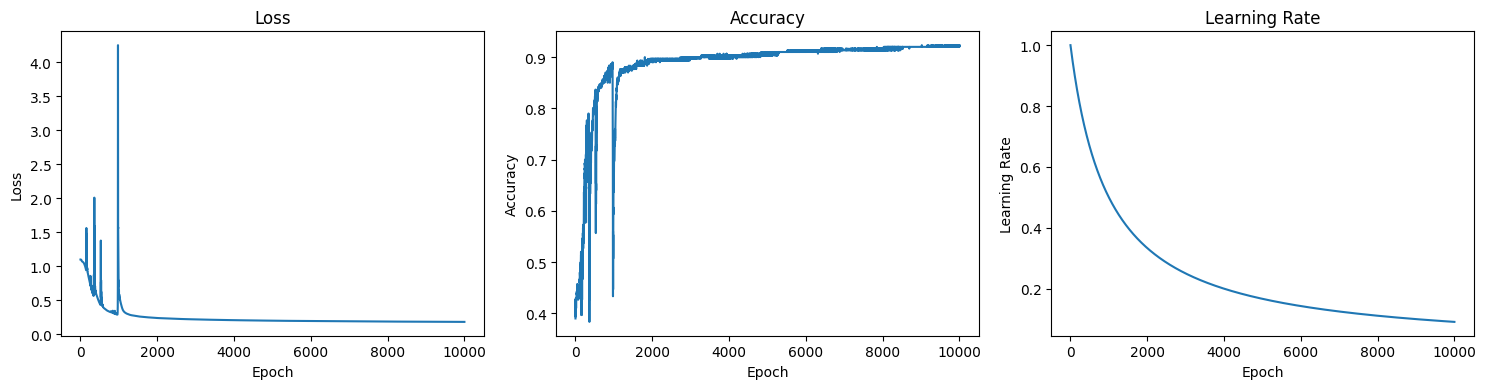

In [16]:
# Training the model with SGD optimizer using momentum and learning rate decay

import numpy as np

# Assuming the necessary classes (Layer_Dense, Activation_ReLU, 
# Activation_Softmax_Loss_CategoricalCrossentropy, Optimizer_SGD, and spiral_data) are defined elsewhere

# Create dataset
X, y = spiral_data(samples=100, classes=3)

losses = []
accuracies = []
learning_rates = []

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_SGD(decay=1e-3, momentum=0.9)

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    losses.append(loss)
    accuracies.append(accuracy)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    learning_rates.append(optimizer.current_learning_rate)

# Plot
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,3,2)
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,3,3)
plt.plot(learning_rates)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()


In [17]:
# Coding ada grade optimizer
class Optimizer_Adagrad:
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate # learning rates changes over time with decay so we are keeping track
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon


    def pre_update_params(self):
        '''
        in this fucntion we decay learning rate
        '''

        if self.decay:
            self.current_learning_rate = self.learning_rate / (1. + self.decay * self.iterations)

    def update_params(self, layer):
        '''
        in this function we update parameters
        '''
        # If layer does not contain cache arrays, create them
        # filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        #accumulate cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        layer.weights = layer.weights - self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases = layer.biases - self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

epoch: 0, acc: 0.360, loss: 1.099, lr: 1.0
epoch: 100, acc: 0.390, loss: 1.031, lr: 0.9099181073703367
epoch: 200, acc: 0.413, loss: 0.987, lr: 0.8340283569641367
epoch: 300, acc: 0.383, loss: 0.961, lr: 0.7698229407236336
epoch: 400, acc: 0.433, loss: 0.947, lr: 0.7147962830593281
epoch: 500, acc: 0.450, loss: 0.938, lr: 0.66711140760507
epoch: 600, acc: 0.500, loss: 0.923, lr: 0.6253908692933083
epoch: 700, acc: 0.507, loss: 0.902, lr: 0.5885815185403178
epoch: 800, acc: 0.513, loss: 0.868, lr: 0.5558643690939411
epoch: 900, acc: 0.547, loss: 0.844, lr: 0.526592943654555
epoch: 1000, acc: 0.550, loss: 0.824, lr: 0.5002501250625312
epoch: 1100, acc: 0.560, loss: 0.809, lr: 0.4764173415912339
epoch: 1200, acc: 0.590, loss: 0.796, lr: 0.45475216007276037
epoch: 1300, acc: 0.593, loss: 0.784, lr: 0.43497172683775553
epoch: 1400, acc: 0.600, loss: 0.772, lr: 0.4168403501458941
epoch: 1500, acc: 0.603, loss: 0.763, lr: 0.4001600640256102
epoch: 1600, acc: 0.617, loss: 0.755, lr: 0.38476337

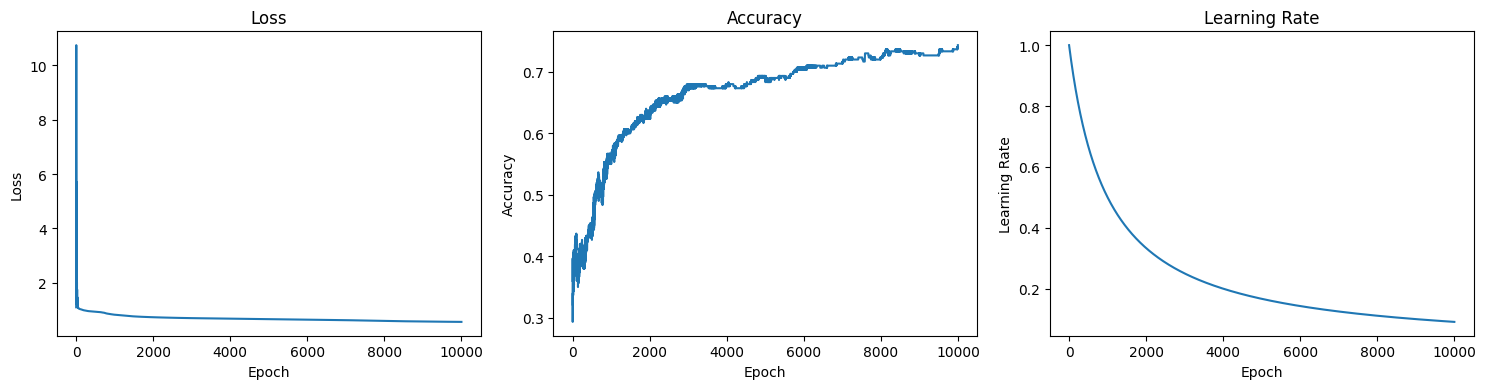

In [18]:
# Training the model with Adagrad optimizer

import numpy as np

X, y = spiral_data(samples=100, classes=3)

losses = []
accuracies = []
learning_rates = []

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adagrad(decay=1e-3)

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    losses.append(loss)
    accuracies.append(accuracy)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass  --->  Back propagation
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    learning_rates.append(optimizer.current_learning_rate)
                            
# Plot
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,3,2)
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,3,3)
plt.plot(learning_rates)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()


In [19]:
# RMSprop Optimizer 

class Optimizer_RMSprop:
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7, cache_decay=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate # learning rates changes over time with decay so we are keeping track
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.cache_decay = cache_decay      


    def pre_update_params(self):
        '''
        in this fucntion we decay learning rate
        '''

        if self.decay:
            self.current_learning_rate = self.learning_rate / (1. + self.decay * self.iterations)

    def update_params(self, layer):
        '''
        in this function we update parameters
        '''
        # If layer does not contain cache arrays, create them
        # filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        #accumulate cache with squared current gradients
        layer.weight_cache  = self.cache_decay * layer.weight_cache + (1 - self.cache_decay) * layer.dweights**2
        layer.bias_cache = self.cache_decay * layer.bias_cache + (1 - self.cache_decay) * layer.dbiases**2

        layer.weights = layer.weights - self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases = layer.biases - self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

epoch: 0, acc: 0.327, loss: 1.099, lr: 0.02
epoch: 100, acc: 0.523, loss: 0.958, lr: 0.01998021958261321
epoch: 200, acc: 0.537, loss: 0.904, lr: 0.019960279044701046
epoch: 300, acc: 0.570, loss: 0.847, lr: 0.019940378268975763
epoch: 400, acc: 0.617, loss: 0.785, lr: 0.01992051713662487
epoch: 500, acc: 0.600, loss: 0.735, lr: 0.01990069552930875
epoch: 600, acc: 0.633, loss: 0.682, lr: 0.019880913329158343
epoch: 700, acc: 0.680, loss: 0.645, lr: 0.019861170418772778
epoch: 800, acc: 0.700, loss: 0.629, lr: 0.019841466681217078
epoch: 900, acc: 0.687, loss: 0.602, lr: 0.01982180200001982
epoch: 1000, acc: 0.690, loss: 0.596, lr: 0.019802176259170884
epoch: 1100, acc: 0.750, loss: 0.552, lr: 0.01978258934311912
epoch: 1200, acc: 0.727, loss: 0.553, lr: 0.01976304113677013
epoch: 1300, acc: 0.737, loss: 0.521, lr: 0.019743531525483964
epoch: 1400, acc: 0.563, loss: 1.088, lr: 0.01972406039507293
epoch: 1500, acc: 0.763, loss: 0.477, lr: 0.019704627631799327
epoch: 1600, acc: 0.767, lo

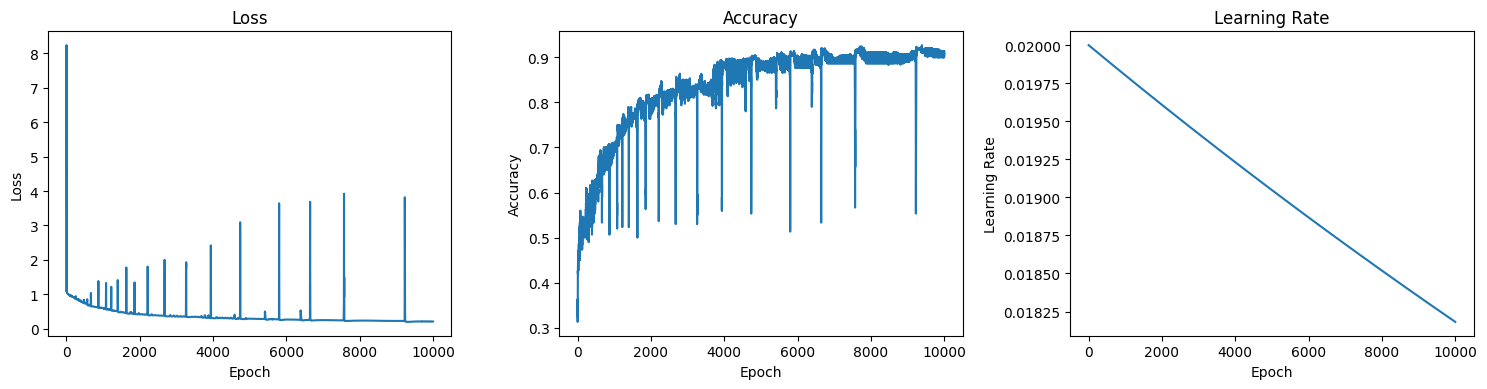

In [20]:
# Training the model with RMSprops optimizer

import numpy as np

X, y = spiral_data(samples=100, classes=3)

losses = []
accuracies = []
learning_rates = []

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_RMSprop(learning_rate=0.02,decay=1e-5, cache_decay=0.999)

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    losses.append(loss)
    accuracies.append(accuracy)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass  --->  Back propagation
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    learning_rates.append(optimizer.current_learning_rate)
                            
# Plot
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,3,2)
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,3,3)
plt.plot(learning_rates)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()


In [21]:
import numpy as np

# Adam optimizer
class Optimizer_Adam:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays, create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Calculate momentum factors (previous weights updates)
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        #calculate numerator
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Calculate weights cache
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        #calculate denominator
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Final updation numerator + denominator
        layer.weights = layer.weights - self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases = layer.biases - self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


epoch: 0, acc: 0.293, loss: 1.099, lr: 0.002
epoch: 100, acc: 0.433, loss: 1.057, lr: 0.0019980219582613214
epoch: 200, acc: 0.437, loss: 1.038, lr: 0.0019960279044701048
epoch: 300, acc: 0.473, loss: 1.017, lr: 0.001994037826897576
epoch: 400, acc: 0.470, loss: 0.990, lr: 0.001992051713662487
epoch: 500, acc: 0.527, loss: 0.951, lr: 0.001990069552930875
epoch: 600, acc: 0.530, loss: 0.906, lr: 0.001988091332915834
epoch: 700, acc: 0.627, loss: 0.859, lr: 0.0019861170418772776
epoch: 800, acc: 0.690, loss: 0.802, lr: 0.0019841466681217077
epoch: 900, acc: 0.740, loss: 0.743, lr: 0.001982180200001982
epoch: 1000, acc: 0.757, loss: 0.691, lr: 0.0019802176259170884
epoch: 1100, acc: 0.770, loss: 0.649, lr: 0.001978258934311912
epoch: 1200, acc: 0.777, loss: 0.612, lr: 0.0019763041136770126
epoch: 1300, acc: 0.793, loss: 0.583, lr: 0.001974353152548396
epoch: 1400, acc: 0.807, loss: 0.556, lr: 0.001972406039507293
epoch: 1500, acc: 0.817, loss: 0.531, lr: 0.001970462763179933
epoch: 1600, 

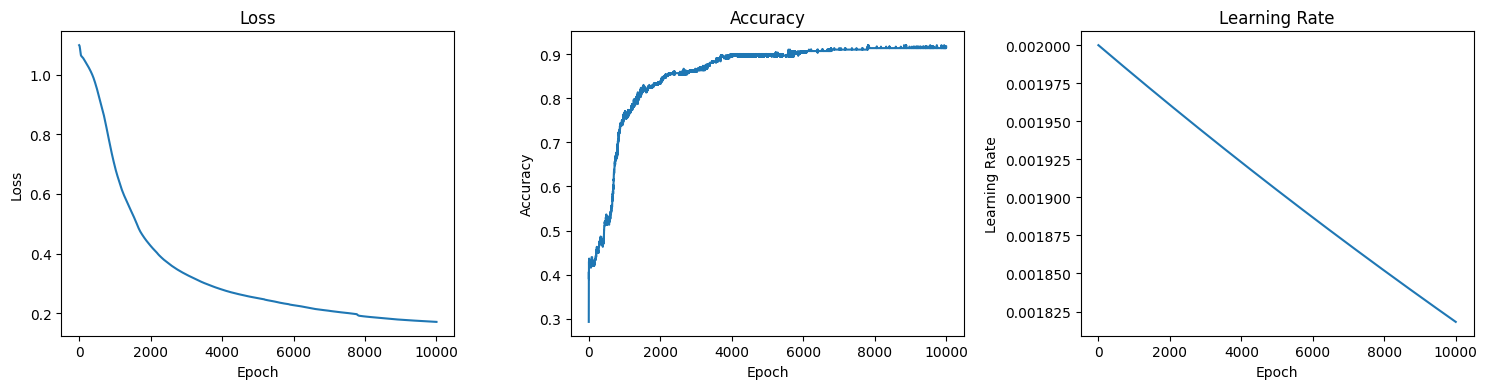

In [25]:
# Training the model with RMSprops optimizer

import numpy as np

X, y = spiral_data(samples=100, classes=3)

losses = []
accuracies = []
learning_rates = []

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adam(learning_rate=0.002,decay=1e-5)

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    losses.append(loss)
    accuracies.append(accuracy)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass  --->  Back propagation
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    learning_rates.append(optimizer.current_learning_rate)
                            
# Plot
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,3,2)
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,3,3)
plt.plot(learning_rates)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()
